Reproduce results in `xi.ipynb` with `zeus21`:
1. $P(k)$
2. (Istropic) correlation function

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import zeus21
from scipy.special import spherical_jn
from zeus21.cosmology import growth, dgrowth_dz, Hub

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [13]:
UserParams = zeus21.User_Parameters(precisionboost=1.2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input(kmax_CLASS=1000.)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

## $P(k)$

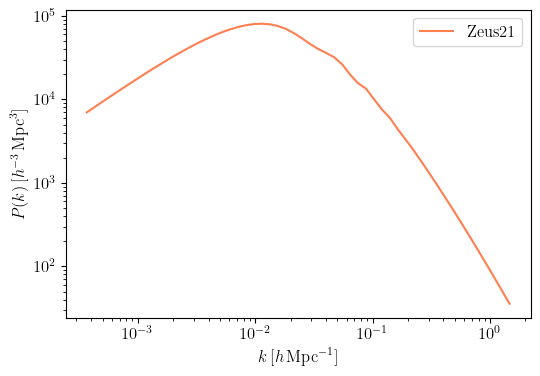

In [14]:
# Get pk from zeus21
k_zeus = CorrFClass._klistCF
pk_zeus = CorrFClass._PklinCF

plt.figure(figsize=(6, 4))
plt.plot(k_zeus, pk_zeus, label='Zeus21', c='coral')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)\,[h^{-3}\,\mathrm{Mpc}^3]$')
plt.legend()

## Correlation function (assuming isotropy)

In [15]:
a = np.linspace(0.01, 1., 1000)
Omega_m0 = 0.31
Omega_L0 = 1. - Omega_m0

def H(a):
    return np.sqrt(Omega_m0 * a**-3 + Omega_L0)

def D(a): # Linear growth factor
    integral = np.trapezoid(1 / (a**3 * (H(a))**3), a)
    D = 5 / 2 * Omega_m0 * H(a) * integral
    D_normalized = D / D[-1]
    return D_normalized

def dD_dtau(D, a):
    dD_da = np.gradient(D, a)
    return dD_da * a**2 * H(a)

dD_dtau_vals = dD_dtau(D(a), a)
D_dot = dD_dtau_vals[-1]

def integrand_v(r):
    return pk_class * spherical_jn(0, k_class*r)

def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_class)

r_list = CorrFClass.rlist_CF
xi_v = [xi_v(r) for r in r_list] # Our result
CF_v = CorrFClass.xi_RR_CF_v
CF_perp = CorrFClass.xi_RR_CF_perp
CF_para = CorrFClass.xi_RR_CF_para

In [23]:
a_list = np.linspace(0.01, 1., 1000)
z_list = 1 / a_list - 1

growth_zeus = growth(CosmoParams, z_list)
dgrowth_zeus = dgrowth_dz(CosmoParams, z_list)

hubble = Hub(CosmoParams, z_list)
dgrowth_dtau = -dgrowth_zeus * hubble

# At z=0
D_dot = dgrowth_dtau[0]

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/zeus21/cosmology.py:346: RuntimeWarning: invalid value encountered in divide
  return (growth(CosmoParams, z+dzlist)-growth(CosmoParams, z-dzlist))/(2.0*dzlist)


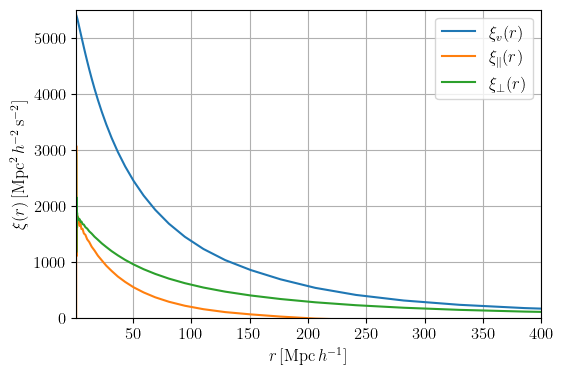

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(r_list, D_dot**2 * CF_v[0, 0, :], label=r'$\xi_v(r)$')

plt.plot(r_list, D_dot**2 * CF_para[0, 0, :], label=r'$\xi_{\parallel}(r)$')
plt.plot(r_list, D_dot**2 * CF_perp[0, 0, :], label=r'$\xi_{\perp}(r)$')
# plt.plot(r_list, np.asarray(xi_v)/3, label=r'$\xi_v(r)/3$ (manual integration)', ls='--')
plt.xlim(1, 400)
plt.ylim(0, 5500)
plt.xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
plt.ylabel(r'$\xi(r)\,[\mathrm{Mpc}^2\,h^{-2}\,\mathrm{s}^{-2}]$')
plt.legend()
plt.grid()